In [1]:
using AutoRisk
using AutoViz
using Reel

In [28]:
include("../collection/heuristic_dataset_config.jl")
include("../collection/collect_heuristic_dataset.jl")
parse_flags!(FLAGS, [])
FLAGS["num_monte_carlo_runs"] = 1
FLAGS["prime_time"] = 10.
FLAGS["sampling_time"] = 5.
# FLAGS["roadway_type"] = "straight"
# FLAGS["roadway_length"] = 10000.
# FLAGS["roadway_length"] =  1000.
# FLAGS["roadway_type"] =  "straight"
# FLAGS["min_num_vehicles"] =  200
# FLAGS["max_num_vehicles"] =  200
# FLAGS["min_base_speed"] =  10.
# FLAGS["max_base_speed"] =  10.
# FLAGS["min_init_dist"] =  15.
FLAGS["overall_response_time"] = 0.2
FLAGS["lon_response_time"] = 0.2
FLAGS["err_p_a_to_i"] =  0.01
FLAGS["err_p_i_to_a"] =  0.3
# FLAGS["min_init_dist"] =  15.
# FLAGS["max_init_dist"] =  5.
# FLAGS["num_lanes"] = 3
# FLAGS["behavior_type"] = "heuristic"
# FLAGS["driver_network_filepath"] = "../../data/policies/gail_gru.h5"
FLAGS["extractor_type"] =  "multi"
FLAGS["extract_road_lidar"] =  false
col = build_dataset_collector("", FLAGS);
Reel.set_output_type("gif");

In [29]:
function Base.show(col::DatasetCollector, seed::Int; target_idx::Int = 1)
    if target_idx <= size(col.eval.targets, 1)
        # this is labeled collisions, but can be any target, selected by target_idx
        in_collision_veh_idxs = find(col.eval.targets[target_idx,:] .== 1.)
    else
        in_collision_veh_idxs = []
    end
    
    # if no collisions then still display the scene, but change car colors
    collisions_exist = in_collision_veh_idxs == [] ? false : true
    collision_color = collisions_exist ? colorant"red" : colorant"orange"
    if !collisions_exist
        in_collision_veh_idxs = sort(collect(values(col.eval.veh_id_to_idx)))
    end
    
    # prepare film for save case
    frames = Frames(MIME("image/png"), fps=10)
    
    # display the record
    @manipulate for follow_veh_idx in in_collision_veh_idxs,
                zoom in collect(1.:2:20.),
                i in 1:(col.eval.rec.nscenes),
                save in [false, true],
                clear in [false, true]
        
        i -= 1
        # set camera
        follow_veh_id = -1
        if follow_veh_idx == 0
            cam = FitToContentCamera()
        else
            for (veh_id, veh_idx) in col.eval.veh_id_to_idx
                if veh_idx == follow_veh_idx
                    follow_veh_id = veh_id
                    break
                end
            end
            cam = CarFollowCamera(follow_veh_id, zoom)
        end

        # render scene
        idx = -(col.eval.rec.nscenes - i) + 1
        carcolors = Dict{Int,Colorant}()
        for veh in get_scene(col.eval.rec, idx)
            carcolors[veh.def.id] = veh.def.id == follow_veh_id ? collision_color : colorant"green"
        end
        mlane = 0
        if typeof(col.models[follow_veh_id]) == DelayedDriver
            mlane = col.models[follow_veh_id].driver.mlane
        elseif typeof(col.models[follow_veh_id]) == Tim2DDriver
            mlane = col.models[follow_veh_id].mlane
        else
            mlane = nothing
        end
        
        stats = follow_veh_id == -1 ? [] : [
            CarFollowingStatsOverlay(follow_veh_id, 2), 
            NeighborsOverlay(follow_veh_id, textparams = TextParams(x = 600, y_start=300))]
        
        if mlane != nothing && typeof(mlane) == MOBIL
            push!(stats, MOBILOverlay(follow_veh_id, mlane))
        end
        
        frame = render(get_scene(col.eval.rec, idx), col.roadway, stats,
            cam = cam, car_colors = carcolors)
        push!(frames, frame)
        
        # to use the save, move around the slider above and collect some frames to write
        # then switch to save, then switch off save
        # this will write the frames, and then clear them
        if save
            filename = "seed_$(seed)_veh_id_$(follow_veh_idx)_target_$(target_idx)"
            write("../../data/visualizations/outputs/$(filename).gif", frames)
            frames = Frames(MIME("image/png"), fps=2)
        end
        
        # to clear frames without saving them set this to true then false
        if clear
            frames = Frames(MIME("image/png"), fps=10)
        end
        
        frame
    end

end

In [30]:
seed = 1
rand!(col, seed)
evaluate!(col.eval, col.scene, col.models, col.roadway, seed);

Interact.Options{:ToggleButtons,Int64}(Signal{Int64}(1, nactions=1),"follow_veh_idx",1,"1",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(11=>"11",134=>"134",158=>"158",160=>"160",29=>"29",131=>"131",173=>"173",74=>"74",176=>"176",57=>"57"…)),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Float64}(Signal{Float64}(1.0, nactions=1),"zoom",1.0,"1.0",Interact.OptionDict(DataStructures.OrderedDict("1.0"=>1.0,"3.0"=>3.0,"5.0"=>5.0,"7.0"=>7.0,"9.0"=>9.0,"11.0"=>11.0,"13.0"=>13.0,"15.0"=>15.0,"17.0"=>17.0,"19.0"=>19.0…),Dict(7.0=>"7.0",9.0=>"9.0",13.0=>"13.0",3.0=>"3.0",19.0=>"19.0",17.0=>"17.0",11.0=>"11.0",5.0=>"5.0",15.0=>"15.0",1.0=>"1.0"…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(75, nactions=1),"i",75,"75",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(68=>"68",148=>"148",124=>"124",2=>"2",89=>"89",11=>"11",39=>"39",46=>"46",85=>"85",134=>"134"…)),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Bool}(Signal{Bool}(false, nactions=1),"save",false,"false",Interact.OptionDict(DataStructures.OrderedDict("false"=>false,"true"=>true),Dict(false=>"false",true=>"true")),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Bool}(Signal{Bool}(false, nactions=1),"clear",false,"false",Interact.OptionDict(DataStructures.OrderedDict("false"=>false,"true"=>true),Dict(false=>"false",true=>"true")),Any[],Any[],true,"horizontal")

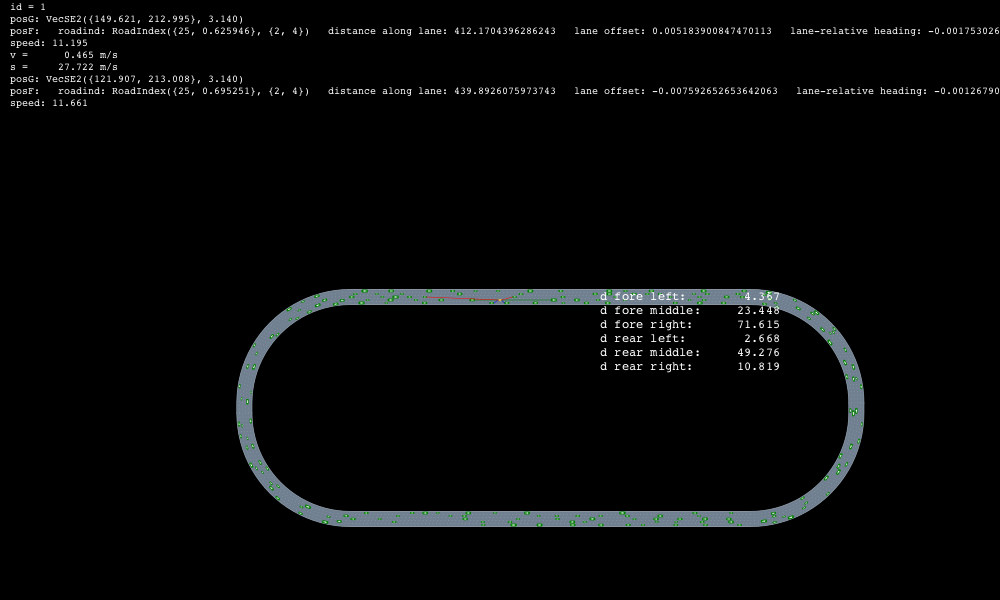

In [31]:
show(col, seed, target_idx = 1)

In [32]:
println(mean(col.eval.agg_targets, 2))

[0.0; 0.0; 0.0; 0.015; 0.005]


In [33]:
println(mean(col.eval.features, 3))

[-0.00138588; 0.000392475; 15.7984; 4.44595; 1.87477; 0.0; 1.50102; 1.49828; 0.0; 0.0; 0.005; 0.965; 0.01; 0.01; 0.2; 1.21625; 4.0; 1.2725; 29.325; 4.5675; 2.2975; 1.64875; 0.2; 3.21625; 2.21625; 0.327; 0.3233; 2.0; 0.965; 0.01; 0.01; 0.2; 1.21625; 4.0; 1.2725; 29.325; 4.5675; 2.2975; 1.64875; 0.2; 3.21625; 2.21625; 0.327; 0.3233; 2.0; 0.96; 0.01; 0.01; 0.2; 1.2275; 4.0; 1.25; 29.55; 4.545; 2.365; 1.6825; 0.2; 3.2275; 2.2275; 0.318; 0.3008; 2.0; 0.98; 0.01; 0.01; 0.2; 1.2475; 4.0; 1.1925; 29.95; 4.505; 2.485; 1.7425; 0.2; 3.2475; 2.2475; 0.302; 0.2825; 2.0; 0.965; 0.01; 0.01; 0.2; 1.21625; 4.0; 1.2725; 29.325; 4.5675; 2.2975; 1.64875; 0.2; 3.21625; 2.21625; 0.327; 0.3233; 2.0; 0.96; 0.01; 0.01; 0.2; 1.17375; 4.0; 1.37625; 28.475; 4.6525; 2.0425; 1.52125; 0.2; 3.17375; 2.17375; 0.361; 0.38505; 2.0; 0.99; 0.01; 0.01; 0.2; 1.16375; 4.0; 1.39; 28.275; 4.6725; 1.9825; 1.49125; 0.2; 3.16375; 2.16375; 0.369; 0.4128; 2.0; 0.965; 0.01; 0.01; 0.2; 1.21625; 4.0; 1.2725; 29.325; 4.5675; 2.2975; 1.

In [ ]:
println(mean(col.eval.features[:,1:length(col.scene)], 2))
println(mean(col.eval.targets[:,1:length(col.scene)], 2))
println(col.eval.features[:,114])
println(col.eval.num_veh)

In [ ]:
function AutoRisk.normalize_input!(network::Network, input::Array{Float64})
    println("normalize")
    input .-= network.means
    input ./= network.stds
end

function AutoRisk.fprop_network(network::Network, input::Array{Float64})
    # fprop through network
    num_layers = length(network.weights)
    state = input
    for lidx in 1:num_layers
        state = state * network.weights[lidx] .+ network.biases[lidx]
        if lidx != num_layers
            # mutates state
            network.nonlinearity(state)
        end
    end
    return sigmoid(state)
end

In [ ]:
seed = 1
reset!(col, seed)
extract_features!(col.eval.rec, col.roadway, col.models, col.eval.prediction_features)
input_dim = size(col.eval.prediction_features, 1)
for vidx in 1:size(features, 2)
    println(size(features[:, vidx]))
    pred = predict(col.eval.prediction_model,  reshape(features[:, vidx], (1, input_dim)))
    println(size(pred))
    println(pred)
end
# println(size(col.eval.prediction_model.means))
# println(size(features))
# normalize_input!(col.eval.prediction_model, features)
# println("predict")
prediction = predict(col.eval.prediction_model, features)

In [ ]:
println(size(prediction))

In [ ]:
carcolors = Dict{Int,Colorant}()
@manipulate for veh_idx in 1:col.scene.n_vehicles,
                zoom in collect(1.:2:20.),
                tidx in collect(1:5)
    for (idx, veh) in enumerate(col.scene)
        carcolors[veh.def.id] = convert(RGB, HSV(prediction[tidx, idx] * 180, 0.85, 0.85))
    end
    cam = CarFollowCamera(colscene[veh_idx].def.id, zoom)
    render(col.scene, col.roadway, cam = cam, car_colors = carcolors)
end

In [ ]:
# function build_collector(flags)
#     num_scenarios = flags["num_scenarios"]
#     output_filepath = flags["output_filepath"]
#     feature_dim = flags["feature_dim"]
#     target_dim = flags["target_dim"]
#     chunk_dim = flags["chunk_dim"]
#     roadway_length = flags["roadway_length"]
#     roadway_radius = flags["roadway_radius"]
#     min_num_veh = flags["min_num_vehicles"]
#     max_num_veh = flags["max_num_vehicles"]
#     min_base_speed = flags["min_base_speed"]
#     max_base_speed = flags["max_base_speed"]
#     min_vehicle_length = flags["min_vehicle_length"]
#     max_vehicle_length = flags["max_vehicle_length"]
#     min_vehicle_width = flags["min_vehicle_width"]
#     max_vehicle_width = flags["max_vehicle_width"]
#     min_init_dist = flags["min_init_dist"]
#     num_lanes = flags["num_lanes"]
#     prime_time = flags["prime_time"]
#     sampling_time = flags["sampling_time"]
#     sampling_period = flags["sampling_period"]
#     num_runs = flags["num_monte_carlo_runs"]
#     veh_idx_can_change = false
#     max_num_samples = flags["num_scenarios"] * max_num_veh 
#     delayed_response = flags["delayed_response"]
#     evaluator_type = flags["evaluator_type"]
#     network_filepath = flags["network_filepath"]
#     sim_time = sampling_time + prime_time

#     # roadway gen
#     roadway = gen_stadium_roadway(num_lanes, length = roadway_length, radius = roadway_radius, ncurvepts_per_turn = 30)
#     roadway_gen = StaticRoadwayGenerator(roadway)

#     # scene gen
#     scene = Scene(max_num_veh)
#     scene_gen = HeuristicSceneGenerator(
#         min_num_veh, 
#         max_num_veh, 
#         min_base_speed,
#         max_base_speed,
#         min_vehicle_length,
#         max_vehicle_length,
#         min_vehicle_width, 
#         max_vehicle_width,
#         min_init_dist)
    
#     # behavior gen
#     params = [get_aggressive_behavior_params(deterministic = false, delayed_response = delayed_response),
#         get_passive_behavior_params(deterministic = false, delayed_response = delayed_response), 
#         get_normal_behavior_params(deterministic = false, delayed_response = delayed_response)]
#     weights = WeightVec([.2,.3,.5])
#     context = IntegratedContinuous(sampling_period, 1)
#     behavior_gen = PredefinedBehaviorGenerator(context, params, weights)
#     models = Dict{Int, DriverModel}()
    
#     # evaluator
#     max_num_scenes = Int((prime_time + sampling_time) / sampling_period)
#     rec = SceneRecord(max_num_scenes, sampling_period, max_num_veh)
#     features = Array{Float64}(feature_dim, max_num_veh)
#     targets = Array{Float64}(target_dim, max_num_veh)
#     agg_targets = Array{Float64}(target_dim, max_num_veh)
#     if evaluator_type == "bootstrap"
#         prediction_model = Network(network_filepath)
#         eval = BootstrappingMonteCarloEvaluator(num_runs, context, prime_time,
#             sampling_time, veh_idx_can_change, rec, features, targets, 
#             agg_targets, prediction_model)
#     else
#         eval = MonteCarloEvaluator(num_runs, context, prime_time, sampling_time,
#         veh_idx_can_change, rec, features, targets, agg_targets)
#     end

#     # dataset
#     dataset = Dataset(output_filepath, feature_dim, target_dim,
#         max_num_samples, chunk_dim = chunk_dim, init_file = false)

#     # collector
#     seeds = collect(1:num_scenarios)
#     col = DatasetCollector(seeds, roadway_gen, scene_gen, behavior_gen, eval,
#         dataset, scene, models, roadway)
    
#     return col
# end

In [ ]:
# function precompute(col::DatasetCollector, seed::Int64)
#     # reset
#     reset!(col, seed)
#     empty!(col.eval.rec)
    
#     # prime
#     simulate!(col.scene, col.models, col.roadway, col.eval.rec, col.eval.prime_time)
    
#     # extract features 
#     extract_features!(col.eval.rec, col.roadway, col.models, col.eval.features)
    
#     # sample
#     empty!(col.eval.veh_id_to_idx)
#     get_veh_id_to_idx(col.scene, col.eval.veh_id_to_idx)
#     prime_idx = col.eval.rec.nscenes
#     simulate!(col.scene, col.models, col.roadway, col.eval.rec, 
#         col.eval.sampling_time)
    
#     # extract targets
#     past_idx = col.eval.rec.nscenes - prime_idx
#     extract_targets!(col.eval.rec, col.roadway, col.eval.targets, 
#         col.eval.veh_id_to_idx, col.eval.veh_idx_can_change, past_idx)
    
# end